# Learning Quantum Optics
## A Notebook for learning how to work with the package [QuantumOptics.jl](https://qojulia.org/)
### Florian Gahbauer
### February 25, 2021
### Revised March 6, 2021

In [1]:
using LinearAlgebra
using QuantumOptics
using WignerSymbols
using PyPlot

## Creating Bases
In this section, we will test the SpinBasis function to create spin-1/2 bases for the electron spin (S1) and the proton spin (S2).
Note that the electron spin is sometimes referred to as S and the proton (nuclear) spin as I.
Then, we will create a composite basis to describe a Hydrogen atom in the 1s state from these two bases. 

In [2]:
m1basis=SpinBasis(1//0)                         # basis for orbital angular momentum S1=L=|S1,m₁> with spin-1. 
m2basis=SpinBasis(1//2)                         # basis for spin S2=|S2,m₂> with spin-1/2  |↑>=[1; 0], |↓>=[0; 1] 
m1m2basis=CompositeBasis(m1basis,m2basis)       # Composite basis S1 ⊗ S2 (outer product)
#hbasis=tensor(sbasis,ibasis) # same as above, I think.
# We will call this the |L,S,mₗ,mₛ> basis or |mₗ,mₛ> for short, because we can describe it 
#by the z-component of each of the spins: |1↑>, |1↓>, |0↑>, |0↓>, |-1↑>, |-1↓> 

[Spin(1/2) ⊗ Spin(1/2)]

## Operators in the spin-1/2 bases
Next we will create some basic operators defined for the spin-1/2 bases. 
We want the $S_z^{1/2 \otimes 1/2}$ operator and the identity operator in each basis. 
To make life easier, we will set $\hbar=1$.

In [3]:
m1basisSz=0.5*sigmaz(m1basis)               # Sz operator for S1 basis: 0.5 \hbar [1 0; 0 -1]
m2basisSz=0.5*sigmaz(m2basis)               # Sz operator for S2 basis: 0.5 \hbar [1 0; 0 -1]
m1basisSplus=sigmap(m1basis)                # Splus operator for S1 basis: \hbar [0 1; 0  0]
m1basisSminus=sigmam(m1basis)               # Sminus operator for S1 basis: \hbar [0 0; 1  0]
m2basisSplus=sigmap(m2basis)                # Splus operator for S2 basis: \hbar [0 1; 0  0]
m2basisSminus=sigmam(m2basis)               # Sminus operator for S1 basis: \hbar [0 0; 1  0]
m1basisIdentity=identityoperator(m1basis)   # Identity operator for S1 basis: [1 0; 0 1]
m2basisIdentity=identityoperator(m2basis)   # Identity operator for S2 basis: [1 0; 0 1]
m1basisSS=0.75*m1basisIdentity              # S^2 operator for S1 basis: 0.75 \hbar^2 [1 0; 0 1]
m2basisSS=0.75*m2basisIdentity              # S^2 operator for S2 basis: 0.75 \hbar^2 [1 0; 0 1]

Operator(dim=2x2)
  basis: Spin(1/2)
  [1, 1]  =  0.75+0.0im
  [2, 2]  =  0.75+0.0im

## Operators in the spin(1/2) $\otimes$ spin(1/2) basis
Now we need to express these operators in the spin(1/2) $\otimes$ spin(1/2) basis. The key is the [outer product](https://en.wikipedia.org/wiki/Outer_product). 



In [4]:
S1z=tensor(m1basisIdentity,m1basisSz)           # S1z in S1S2 basis: \hbar diagonal(0.5,0.5,-0.5,-0.5)
S2z=tensor(m2basisSz,m2basisIdentity)           # S2z in S1S2 basis: \hbar digaonal(0.5,-0.5,0.5,-0.5)
S1plus=tensor(m1basisIdentity,m1basisSplus)     # S1plus in S1S2 basis 
S1minus=tensor(m1basisIdentity,m1basisSminus)   # S1minus in S1S2 basis
S2plus=tensor(m2basisSplus,m2basisIdentity)     # S2plus in S1S2 basis 
S2minus=tensor(m2basisSminus,m2basisIdentity)   # S2minus in S1S2 basis
S1S2=S1z*S2z+0.5*(S2plus*S1minus+S2minus*S1plus)    # S1̇ S2 in S1S2 basis
#See eq. (E-19) of Chapter XII.3.b. of Cohen-Tannoudji Quantum Mechanics for S=S1, I=S2


Operator(dim=4x4)
  basis: [Spin(1/2) ⊗ Spin(1/2)]
  [1, 1]  =  0.25+0.0im
  [2, 2]  =  -0.25+0.0im
  [3, 2]  =  0.5+0.0im
  [2, 3]  =  0.5+0.0im
  [3, 3]  =  -0.25+0.0im
  [4, 4]  =  0.25+0.0im

In [5]:
# Now define S^2 in the S1S2 basis. 
# See eq (B-18) of Chapter X of Cohen-Tannoudji Quantum Mechanics
# Should be \hbar^2 [2 0 0 0; 0 1 1 0; 0 1 1 0; 0 0 0 2]
SS=0.75*identityoperator(m1m2basis) + 0.75*identityoperator(m1m2basis) + 2*S1z*S2z +S1plus*S2minus +S1minus*S2plus 

Operator(dim=4x4)
  basis: [Spin(1/2) ⊗ Spin(1/2)]
  [1, 1]  =  2.0+0.0im
  [2, 2]  =  1.0+0.0im
  [3, 2]  =  1.0+0.0im
  [2, 3]  =  1.0+0.0im
  [3, 3]  =  1.0+0.0im
  [4, 4]  =  2.0+0.0im

In [6]:
# Now define some kets in the S1S2 basis.
uu=Ket(m1m2basis,[1,0,0,0])        # | ↑, ↑ >
dd=Ket(m1m2basis,[0,0,0,1])        # | ↓, ↓ >
ud=Ket(m1m2basis,[0,1,0,0])        # | ↑, ↓ >
du=Ket(m1m2basis,[0,0,1,0])        # | ↓, ↑ >

Ket(dim=4)
  basis: [Spin(1/2) ⊗ Spin(1/2)]
 0.0
 0.0
 1.0
 0.0

In [7]:
# Now define the basis vectors of the |F, m> basis, 
# where the total angular momentum F=S1+S2 and m=Fz (the z-component of F)
F1=uu                                       # | ↑, ↑ >
F2=(ud+du)/sqrt(2)                          # (| ↑, ↓ > + | ↓, ↑ >)/√2
F3=dd                                       # | ↓, ↓ >
F4=(ud-du)/sqrt(2)                          # (| ↑, ↓ > - | ↓, ↑ >)/√2
Fmbasis=SubspaceBasis([F1,F2,F3,F4])         # Now define the |F,m> basis using these basis vectors

Subspace(superbasis=[Spin(1/2) ⊗ Spin(1/2)], states:4)

In [8]:
# Now define the matrix to transform a vector from the |m1,m2> basis to the |F,m> basis.
# In other words, we found |α> = C |β>, where |α> is in the |F,m> basis and β is in the |m1,m2> basis.
# A good explanation can be  found in the section on Clebsch-Gordan coefficients in
# R. Shankar, Principles of Quantum Mechanics, 2nd edition, New York, Plenum Press, 1994 (ISBN 0-306-44790-8)
# In fact, I found the entire chapter on Addition of Angular momentum (Chapter 15) very helpful.
C=[clebschgordan(1//2,1//2,1//2,1//2,1,1) clebschgordan(1//2,1//2,1//2,-1//2,1,1) clebschgordan(1//2,-1//2,1//2,1//2,1,1) clebschgordan(1//2,-1//2,1//2,-1//2,1,1);
    clebschgordan(1//2,1//2,1//2,1//2,1,0) clebschgordan(1//2,1//2,1//2,-1//2,1,0) clebschgordan(1//2,-1//2,1//2,1//2,1,0) clebschgordan(1//2,-1//2,1//2,-1//2,1,0);
    clebschgordan(1//2,1//2,1//2,1//2,1,-1) clebschgordan(1//2,1//2,1//2,-1//2,1,-1) clebschgordan(1//2,-1//2,1//2,1//2,1,-1) clebschgordan(1//2,-1//2,1//2,-1//2,1,-1);
    clebschgordan(1//2,1//2,1//2,1//2,0,0) clebschgordan(1//2,1//2,1//2,-1//2,0,0) clebschgordan(1//2,-1//2,1//2,1//2,0,0) clebschgordan(1//2,-1//2,1//2,-1//2,0,0)]

4×4 Array{RationalRoots.RationalRoot{BigInt},2}:
 +√(1//1)  +√(0//1)  +√(0//1)  +√(0//1)
 +√(0//1)  +√(1//2)  +√(1//2)  +√(0//1)
 +√(0//1)  +√(0//1)  +√(0//1)  +√(1//1)
 +√(0//1)  +√(1//2)  -√(1//2)  +√(0//1)

In [9]:
# C is just a matrix for now. It is not a QuantumOptics object.
# Therefore we can just take the inverse using the appropriate 
# function from the LinearAlgebra package. 
# Following the above logic, Cinv is the transormation matrix 
# from the |F,m> basis to the |m1,m2> basis:
# |β> = Cinv |α>,
# where |β> is a ket in the |m1,m2> basis 
# and |α> is a ket in the |F,m> basis.
Cinv=inv(C)

4×4 Array{Float64,2}:
 1.0  -0.0       -0.0   0.0
 0.0   0.707107  -0.0   0.707107
 0.0   0.707107   0.0  -0.707107
 0.0   0.0        1.0   0.0

In [10]:
# The elements of C are type RationalRoots.
# We want them to be Float64. 
# We use the vectorized dot-function Float64 
# to convert each element of C to a Float64.
C=Float64.(C)

4×4 Array{Float64,2}:
 1.0  0.0        0.0       0.0
 0.0  0.707107   0.707107  0.0
 0.0  0.0        0.0       1.0
 0.0  0.707107  -0.707107  0.0

In [11]:
# Now we want to convert our matrix into an operator object.
# We use the DenseOperator function from QuantumOptics.jl 
# and define a transformmatrix. 
TransformMatrix=DenseOperator(m1m2basis,C)

Operator(dim=4x4)
  basis: [Spin(1/2) ⊗ Spin(1/2)]
 1.0+0.0im       0.0+0.0im        0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.707107+0.0im   0.707107+0.0im  0.0+0.0im
 0.0+0.0im       0.0+0.0im        0.0+0.0im  1.0+0.0im
 0.0+0.0im  0.707107+0.0im  -0.707107+0.0im  0.0+0.0im

In [12]:
# We also need the Hermitian conjugate of the 
# transform matrix, which we can get using the 
# dagger function from QuantumOptics.jl. 
TransformMatrixDagger=dagger(TransformMatrix)

Operator(dim=4x4)
  basis: [Spin(1/2) ⊗ Spin(1/2)]
 1.0-0.0im       0.0-0.0im  0.0-0.0im        0.0-0.0im
 0.0-0.0im  0.707107-0.0im  0.0-0.0im   0.707107-0.0im
 0.0-0.0im  0.707107-0.0im  0.0-0.0im  -0.707107-0.0im
 0.0-0.0im       0.0-0.0im  1.0-0.0im        0.0-0.0im

In [14]:
# In order to transform the operator Sz from the |m₁,m₂> basis to the
# |F,m> basis, we must multiply it on the right side by
# C† and on the left side by C. 
TransformMatrix*(S1z)*TransformMatrixDagger    # Should be Eq. E-10 in Chapter XII.E.2.a. of vol. 2 of Cohen-Tannoudji.

Operator(dim=4x4)
  basis: [Spin(1/2) ⊗ Spin(1/2)]
 0.5+0.0im      0.0+0.0im   0.0+0.0im      0.0+0.0im
 0.0+0.0im  2.0e-17+0.0im   0.0+0.0im      0.5+0.0im
 0.0+0.0im      0.0+0.0im  -0.5+0.0im      0.0+0.0im
 0.0+0.0im      0.5+0.0im   0.0+0.0im  2.0e-17+0.0im

In [15]:
# I think the right way to do it, actually, is to define our transform matrix
# as an operator with a left-side basis |F,m>
# and a right-side basis |m₁,m₂>. 
TransformMatrix=Operator(Fmbasis,m1m2basis,C)

Operator(dim=4x4)
  basis left:  Subspace(superbasis=[Spin(1/2) ⊗ Spin(1/2)], states:4)
  basis right: [Spin(1/2) ⊗ Spin(1/2)]
 1.0  0.0        0.0       0.0
 0.0  0.707107   0.707107  0.0
 0.0  0.0        0.0       1.0
 0.0  0.707107  -0.707107  0.0

In [16]:
# Now when we take the Hermitian conjugage, the QuantumOptics package
# should handle everything for us. 
TransformMatrixDagger=dagger(TransformMatrix)

Operator(dim=4x4)
  basis left:  [Spin(1/2) ⊗ Spin(1/2)]
  basis right: Subspace(superbasis=[Spin(1/2) ⊗ Spin(1/2)], states:4)
 1.0  0.0       0.0   0.0
 0.0  0.707107  0.0   0.707107
 0.0  0.707107  0.0  -0.707107
 0.0  0.0       1.0   0.0

In [17]:
Szfmbasis=TransformMatrix*(S1z)*TransformMatrixDagger    # Eq. E-10 in Chapter XII.E.2.a. of vol. 2 of Cohen-Tannoudji, Quantum Mechanics.

Operator(dim=4x4)
  basis: Subspace(superbasis=[Spin(1/2) ⊗ Spin(1/2)], states:4)
 0.5+0.0im      0.0+0.0im   0.0+0.0im      0.0+0.0im
 0.0+0.0im  2.0e-17+0.0im   0.0+0.0im      0.5+0.0im
 0.0+0.0im      0.0+0.0im  -0.5+0.0im      0.0+0.0im
 0.0+0.0im      0.5+0.0im   0.0+0.0im  2.0e-17+0.0im

In [19]:
ISfmbasis=TransformMatrix*(S1S2)*TransformMatrixDagger   # This is the operator I.S in the |F,m> basis, where it should be diagonal. 

Operator(dim=4x4)
  basis: Subspace(superbasis=[Spin(1/2) ⊗ Spin(1/2)], states:4)
 0.25+0.0im      0.0+0.0im   0.0+0.0im      0.0+0.0im
  0.0+0.0im     0.25+0.0im   0.0+0.0im  1.0e-17+0.0im
  0.0+0.0im      0.0+0.0im  0.25+0.0im      0.0+0.0im
  0.0+0.0im  2.0e-17+0.0im   0.0+0.0im    -0.75+0.0im

In [20]:
#  Now I think we are ready to calculate the Zeeman splitting. 
A=1420.405751768                # Hyperfine structure of the ground state of H, A*hbar/(2*pi), in MHz. 
q=1.6*10^(-19)                  # Electron charge in Coulomb
mₑ=9.1*10^(-31)                 # Electron mass in kg
B₀=range(0,0.05,step=0.0001)    # 1.0*10^(-4)     Magnetic field in Tesla
ω₀=-(q/(2*mₑ))*B₀/10^6          # frequency in MHz

0.0:-8.791208791208788:-4395.604395604394

In [21]:
Hlist = [A*S1S2 + 2 * ω * S1z for ω=ω₀]         # The Hamiltonian is given by eq. (E-8) in Chapter XII.E.1.b. of Cohen-Tannoudji, Quantum Mechanics 
results=[eigenstates(dense(H)) for H=Hlist]; # This is a way of looping over the elements in the array Hlist to get an array called results.


In [22]:
# Lots of information packed into the results array.
typeof(results)

Array{Tuple{Array{Float64,1},Array{Ket{CompositeBasis{Array{Int64,1},Tuple{SpinBasis{1//2,Int64},SpinBasis{1//2,Int64}}},Array{Complex{Float64},1}},1}},1}

In [23]:
# Check the length. (How many entries
length(results)

501

In [24]:
# Here we unpack the Eigenvalues and create 1-dimensional arrays for each Eigenvalue at different magnetic field values.
E1=[results[i][1][1] for i=range(1,length=length(results))]
E2=[results[i][1][2] for i=range(1,length=length(results))]
E3=[results[i][1][3] for i=range(1,length=length(results))]
E4=[results[i][1][4] for i=range(1,length=length(results))];

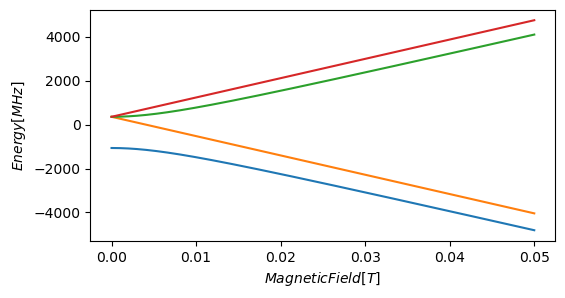

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000618175B0>

In [25]:
#  Now we plot each Eigenvalue as a function of magnetic field. 
figure(figsize=(6,3))
xlabel(L"Magnetic Field [T]")
ylabel(L"Energy [MHz]")
plot(B₀,E1)
plot(B₀,E2)
plot(B₀,E3)
plot(B₀,E4)



In [26]:
# This command just gives us information about the packages used in our environment.
# The information is stored in a Manifest.toml file.  
# It is useful for reproducing the environment on another machine, for example, 
# using mybinder.org.
using Pkg
Pkg.status(mode=PKGMODE_MANIFEST)

Status `C:\Users\User\.julia\environments\v1.5\Manifest.toml`
  [621f4979] AbstractFFTs v1.0.0
  [1520ce14] AbstractTrees v0.3.3
  [79e6a3ab] Adapt v2.4.0
  [ec485272] ArnoldiMethod v0.1.0
  [7d9fca2a] Arpack v0.5.1
  [68821587] Arpack_jll v3.5.0+3
  [4fba245c] ArrayInterface v3.0.1
  [56f22d72] Artifacts v1.3.0
  [bf4720bc] AssetRegistry v0.1.0
  [c52e3926] Atom v0.12.30
  [00ebfdb7] CSTParser v2.5.0
  [d360d2e6] ChainRulesCore v0.9.27
  [53a63b46] CodeTools v0.7.1
  [da1fd8a2] CodeTracking v1.0.5
  [3da002f7] ColorTypes v0.10.9
  [5ae59095] Colors v0.12.6
  [a80b9123] CommonMark v0.6.4
  [38540f10] CommonSolve v0.2.0
  [bbf7d656] CommonSubexpressions v0.3.0
  [34da2185] Compat v3.25.0
  [e66e0078] CompilerSupportLibraries_jll v0.3.4+0
  [8f4d0f93] Conda v1.5.0
  [187b0558] ConstructionBase v1.0.0
  [a8cc5b0e] Crayons v4.0.4
  [9a962f9c] DataAPI v1.5.1
  [864edb3b] DataStructures v0.18.9
  [e2d170a0] DataValueInterfaces v1.0.0
  [2b5f629d] DiffEqBase v6.57.1
  [459566f4] DiffEqCallbac

In [27]:
# This command write a Project.toml file, which is useful if we want to recreate the environment on another machine.
pkg"status"

Status `C:\Users\User\.julia\environments\v1.5\Project.toml`
  [c52e3926] Atom v0.12.30
  [7073ff75] IJulia v1.23.1
  [e5e0dc1b] Juno v0.8.4
  [d330b81b] PyPlot v2.9.0
  [6e0679c1] QuantumOptics v0.8.4
  [9f57e263] WignerSymbols v1.1.0
